In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import optimize
import umodel as unf

import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [3]:
# Loading data cos(n, -)
with open('../data/CosThetaNminus/asimov_spinCorrelation.json', 'r') as read_file:
    dm = np.array(json.load(read_file))
    
with open('../data/CosThetaNminus/resmat_spinCorrelation.json', 'r') as read_file:
    rm = np.array(json.load(read_file))
    
# Loading data cos(n, +)
with open('../data/CosThetaNplus/asimov_spinCorrelation.json', 'r') as read_file:
    dp = np.array(json.load(read_file))
    
with open('../data/CosThetaNplus/resmat_spinCorrelation.json', 'r') as read_file:
    rp = np.array(json.load(read_file))

    
# Loading data correlations between the two observables
with open('../data/correlation_matrix_CosThetaNplus_CosThetaNminus_bins.json', 'r') as read_file:
    corrDict = json.load(read_file)

In [4]:
n, p = rm.shape[0], rp.shape[0]
corr = np.zeros((n+p, n+p))
for i, (iName, line) in enumerate(corrDict.items()):
    for j, (jName, c) in enumerate(line.items()):
        corr[i, j] = c

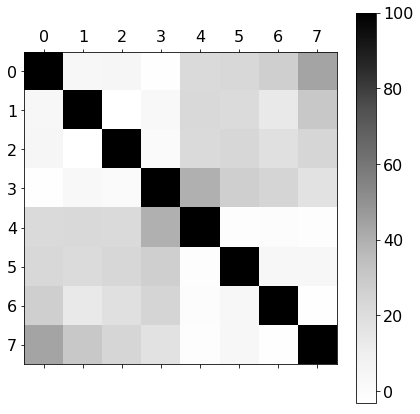

In [5]:
plt.matshow(corr*100, cmap='Greys')
plt.colorbar();

In [6]:
Ds = [dp, dm]
Rs = [rp, rm]

In [8]:
# With correlation
mCorr = unf.model(Ds, Rs, corr)
BsCorr, _ = mCorr.unfold()
POIsCorr = mCorr.postFitUncerPOIs()

In [9]:
# Without correlations
m = unf.model(Ds, Rs, corr=np.diag([1]*8))
Bs, _ = m.unfold()
POIs = m.postFitUncerPOIs()

In [10]:
# Comparing result w/ and w/o corr from direct unfolding (full minimzation, only central values)
# --> no differences
bpCorr = BsCorr[0]
bmCorr = BsCorr[1]
bp = Bs[0]
bm = Bs[1]
print((bpCorr-bp)/bp)
print((bmCorr-bm)/bm)

[ 4.49861146e-16  2.10668630e-15  1.50490481e-16 -5.99850426e-16]
[-6.00128489e-16  7.52049961e-16  3.00898988e-16  7.49953360e-16]


In [12]:
# Comparing results w/ and w/o corr from profile LH
# --> differences from ~1% to 20% level!
POIsCorr = np.concatenate(POIsCorr)
POIs = np.concatenate(POIs)
relDiff = (POIsCorr-POIs) / POIs[:, 0, np.newaxis]
print( relDiff[:, 0] )

[ 4.49726093e-16 -6.00420294e-04 -6.00420294e-04 -5.82407685e-02
 -6.00420294e-04 -6.00420294e-04 -6.00420294e-04 -6.00420294e-04]


In [13]:
# Comparing results between unfolded and profile, w/o corr
# --> no differences
for m1, m2 in zip(POIs, np.concatenate([bp, bm])):
    print((m1[0] - m2)/m1[0])

0.00030021014710291316
0.00030021014710301263
0.0003002101471029003
0.0003002101471030122
0.0003002101471029213
0.0003002101471030009
0.00030021014710294205
0.00030021014710291804


In [14]:
# Comparing results between unfolded and profiled, w/ corr
# --> large differences (from ~3% to 25%)!
for m1, m2 in zip(POIsCorr, np.concatenate([bpCorr, bmCorr])):
    print((m1[0] - m2)/m1[0])

0.00030021014710291305
-0.0003003905076599979
-0.0003003905076600366
-0.06152374880459035
-0.00030039050765990726
-0.0003003905076599866
-0.0003003905076599278
-0.00030039050766005374


# WHY ??

 + check by hand the profile for `bm[1]` bin and compare with the full minimum

In [24]:
def f(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

def plotProfile(i):
    val1, nll1 = m.profilePOI(iPOI=i, POImin=0.74e9, POImax=0.85e9, nScan=20)
    p1, _ = optimize.curve_fit(f, val1, nll1)
    plt.plot(val1, nll1, 'o', color='tab:blue')
    v1 = np.linspace(val1.min(), val1.max(), 1000)
    n1 = f(v1, *p1)
    plt.plot(v1, n1, color='tab:blue')
    
    val2, nll2 = mCorr.profilePOI(iPOI=i, POImin=0.74e9, POImax=0.85e9, nScan=20)
    p2, _ = optimize.curve_fit(f, val2, nll2)
    plt.plot(val2, nll2, 'o', color='tab:red')
    v2 = np.linspace(val2.min(), val2.max(), 1000)
    n2 = f(v2, *p2)
    plt.plot(v2, n2, color='tab:red')

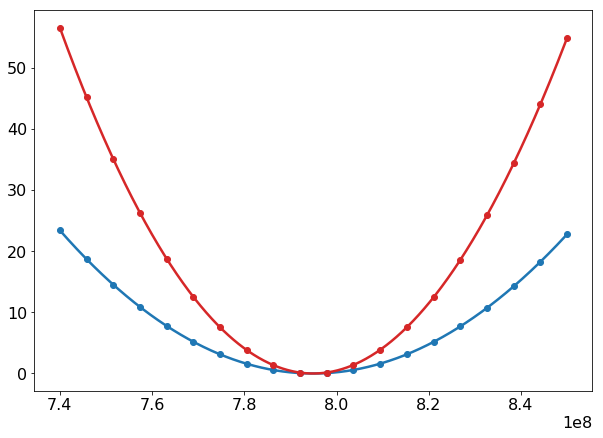

In [25]:
plotProfile(3)